In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Data Understanding

In [48]:
df = pd.read_csv('housePrice.csv', encoding='ISO-8859-1')


In [49]:
df.head(5)

,Area,Room,Parking,Warehouse,Elevator,Address,Price,Price(USD)
0,63,1,True,True,True,Shahran,1.850000e+09,61666.67
1,60,1,True,True,True,Shahran,1.850000e+09,61666.67
2,79,2,True,True,True,Pardis,5.500000e+08,18333.33
3,95,2,True,True,True,Shahrake Qods,9.025000e+08,30083.33
4,123,2,True,True,True,Shahrake Gharb,7.000000e+09,233333.33


In [50]:
df = df.drop("Price", axis = 1)

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3479 entries, 0 to 3478
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Area        3479 non-null   object 
 1   Room        3479 non-null   int64  
 2   Parking     3479 non-null   bool   
 3   Warehouse   3479 non-null   bool   
 4   Elevator    3479 non-null   bool   
 5   Address     3456 non-null   object 
 6   Price(USD)  3479 non-null   float64
dtypes: bool(3), float64(1), int64(1), object(2)
memory usage: 119.0+ KB


In [52]:
df['Area'] = pd.to_numeric(df['Area'], errors='coerce')


In [53]:
df.isnull().sum()

Area           6
Room           0
Parking        0
Warehouse      0
Elevator       0
Address       23
Price(USD)     0
dtype: int64

The number of nulls is much less than 5% of the data, so it is best to delete those rows, as it has little negative impact on the model and the data becomes cleaner.

In [54]:
df = df.dropna()

In [55]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Area,3450.0,106.917391,69.550976,30.0,69.0000,90.00,120.0,929.0
Room,3450.0,2.081159,0.760216,0.0,2.0000,2.00,2.0,5.0
Price(USD),3450.0,179185.420345,270863.932158,120.0,47308.3325,96666.67,200000.0,3080000.0


In [56]:
df['Address'].value_counts()

Address
Punak                     161
Pardis                    146
West Ferdows Boulevard    145
Gheitarieh                140
Shahran                   130
                         ... 
Chardangeh                  1
Mehrabad                    1
Pakdasht KhatunAbad         1
Kazemabad                   1
Yakhchiabad                 1
Name: count, Length: 192, dtype: int64

In [57]:
df['Avg_Price_By_address'] = df.groupby('Address')['Price(USD)'].transform('mean')
df.sample(8)

,Area,Room,Parking,Warehouse,Elevator,Address,Price(USD),Avg_Price_By_address
1196,87.0,2,True,True,True,West Ferdows Boulevard,126666.67,103524.827724
2443,80.0,2,True,True,True,Ekhtiarieh,146666.67,337801.588095
2427,130.0,4,False,False,False,Mehrabad,206666.67,206666.670000
453,94.0,2,True,False,True,Pardis,33000.00,25927.397329
3266,85.0,2,True,True,True,Shahr-e-Ziba,96666.67,103462.997248
1870,90.0,2,True,True,True,Ekhtiarieh,200000.00,337801.588095
2220,105.0,3,True,True,True,Shahr-e-Ziba,118333.33,103462.997248
2562,76.0,2,True,True,False,West Ferdows Boulevard,66333.33,103524.827724


In [58]:
'''cols = ['Area','Room','Price(USD)']

# آمار قبل از clip
print("آمار قبل از محدودسازی:")
print(df[cols].describe())

# اعمال clip
for col in cols:
    df[col] = df[col].clip(lower=Lower_bound[col], upper=Upper_bound[col])

# آمار بعد از clip
print("\nآمار بعد از محدودسازی:")
print(df[cols].describe())'''


'cols = [\'Area\',\'Room\',\'Price(USD)\']\n\n# آمار قبل از clip\nprint("آمار قبل از محدودسازی:")\nprint(df[cols].describe())\n\n# اعمال clip\nfor col in cols:\n    df[col] = df[col].clip(lower=Lower_bound[col], upper=Upper_bound[col])\n\n# آمار بعد از clip\nprint("\nآمار بعد از محدودسازی:")\nprint(df[cols].describe())'

In [59]:
'''cols = ['Area','Room','Price(USD)']

Q1 = df[cols].quantile(0.25)
Q3 = df[cols].quantile(0.75)
IQR = Q3 - Q1

Lower_bound = Q1 - 1.5 * IQR
Upper_bound = Q3 + 1.5 * IQR


for col in cols:
    df[col] = df[col].clip(lower=Lower_bound[col], upper=Upper_bound[col])'''


"cols = ['Area','Room','Price(USD)']\n\nQ1 = df[cols].quantile(0.25)\nQ3 = df[cols].quantile(0.75)\nIQR = Q3 - Q1\n\nLower_bound = Q1 - 1.5 * IQR\nUpper_bound = Q3 + 1.5 * IQR\n\n\nfor col in cols:\n    df[col] = df[col].clip(lower=Lower_bound[col], upper=Upper_bound[col])"

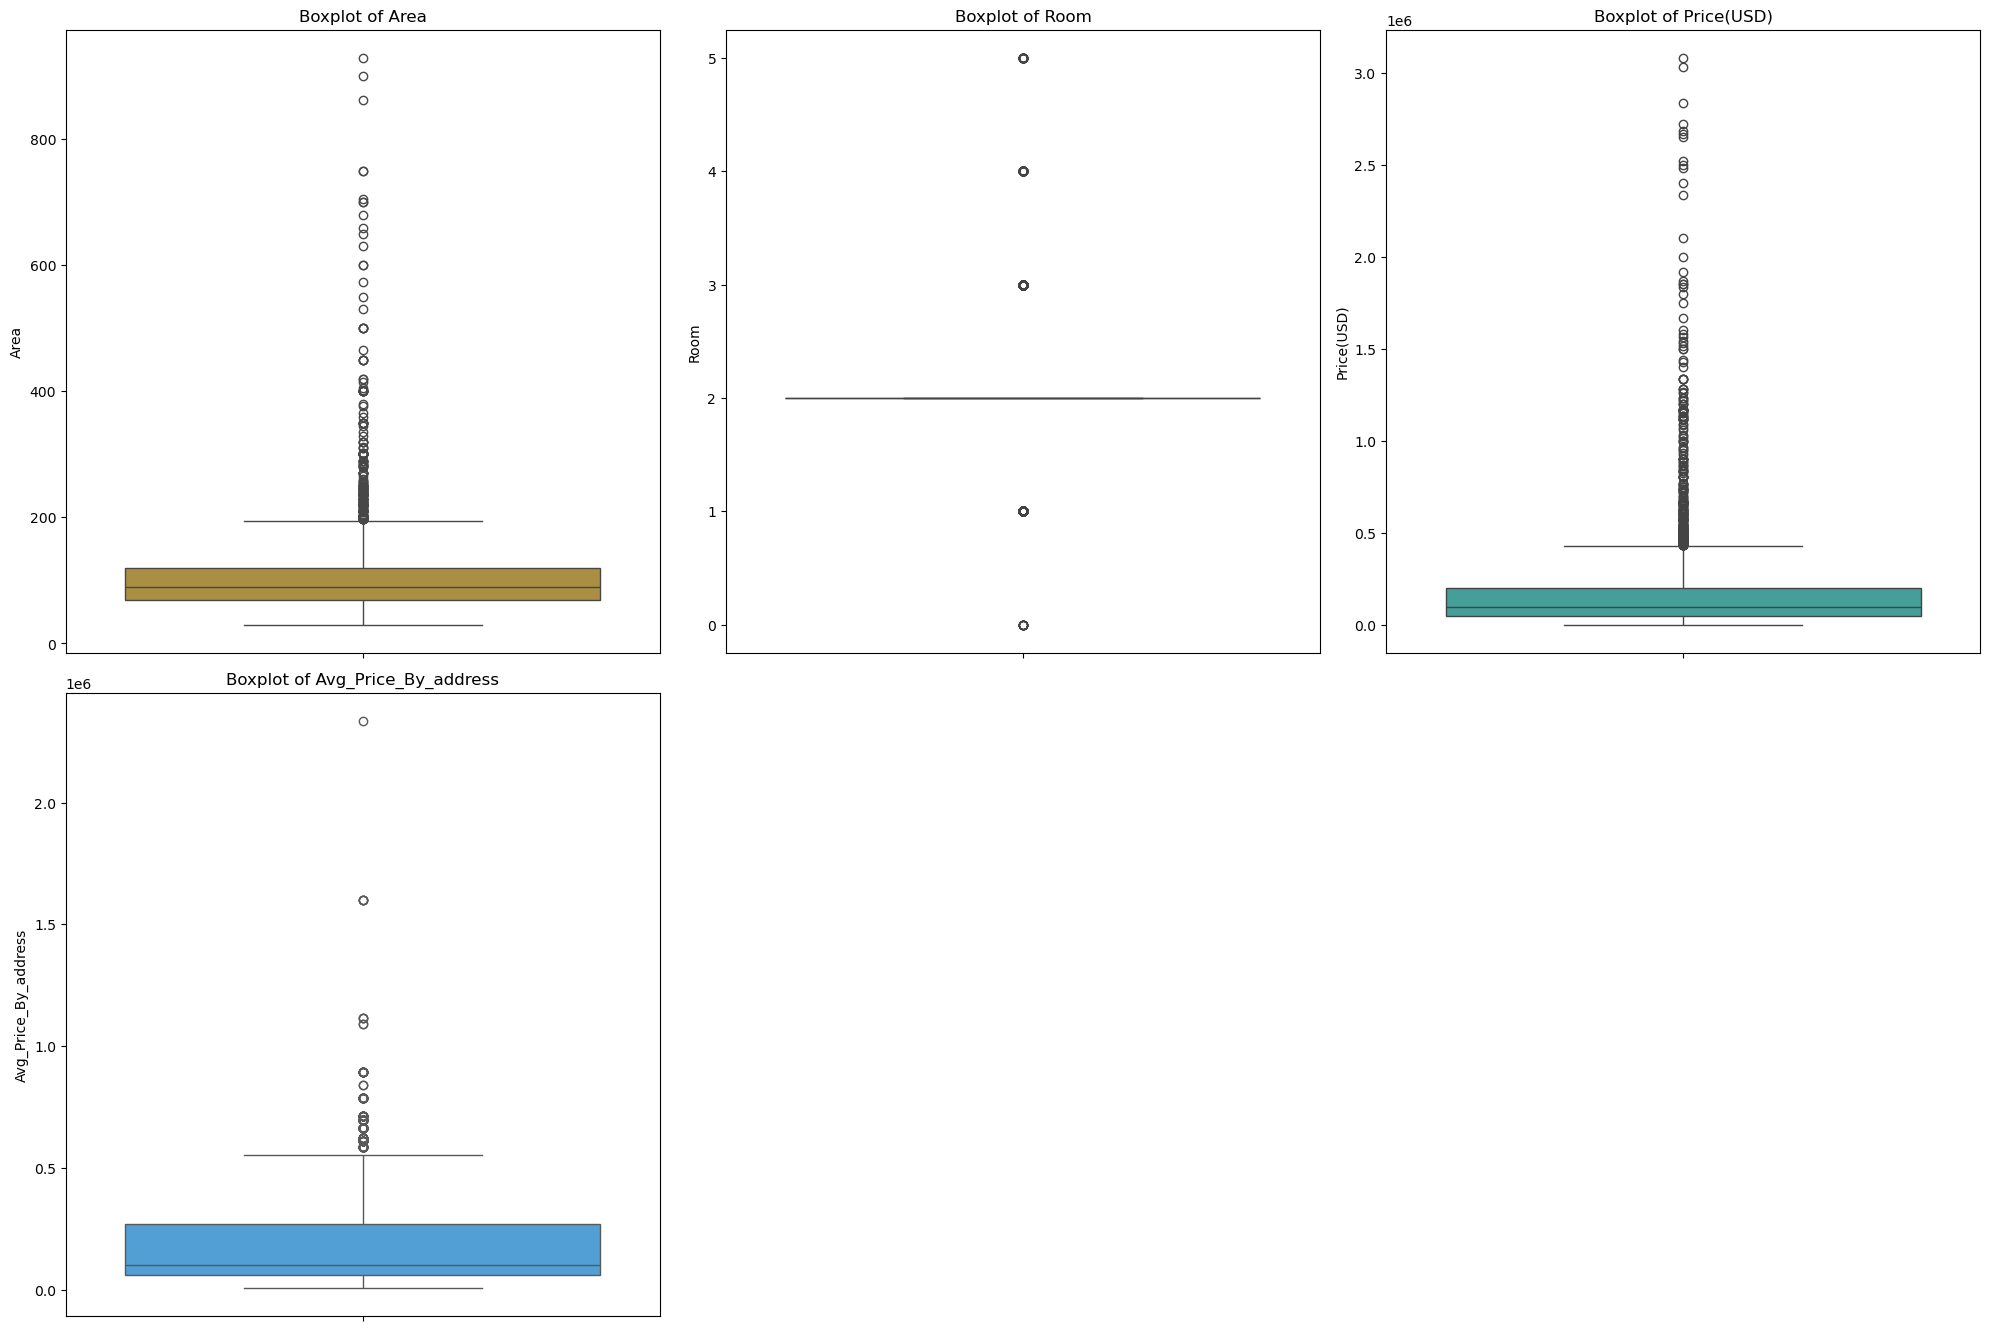

In [60]:
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Define color palette
palette = sns.color_palette("husl")

#to show Outliers in data 
plt.figure(figsize=(20, 20))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(3,3, i)
    sns.boxplot(y=df[col], color=palette[i])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()


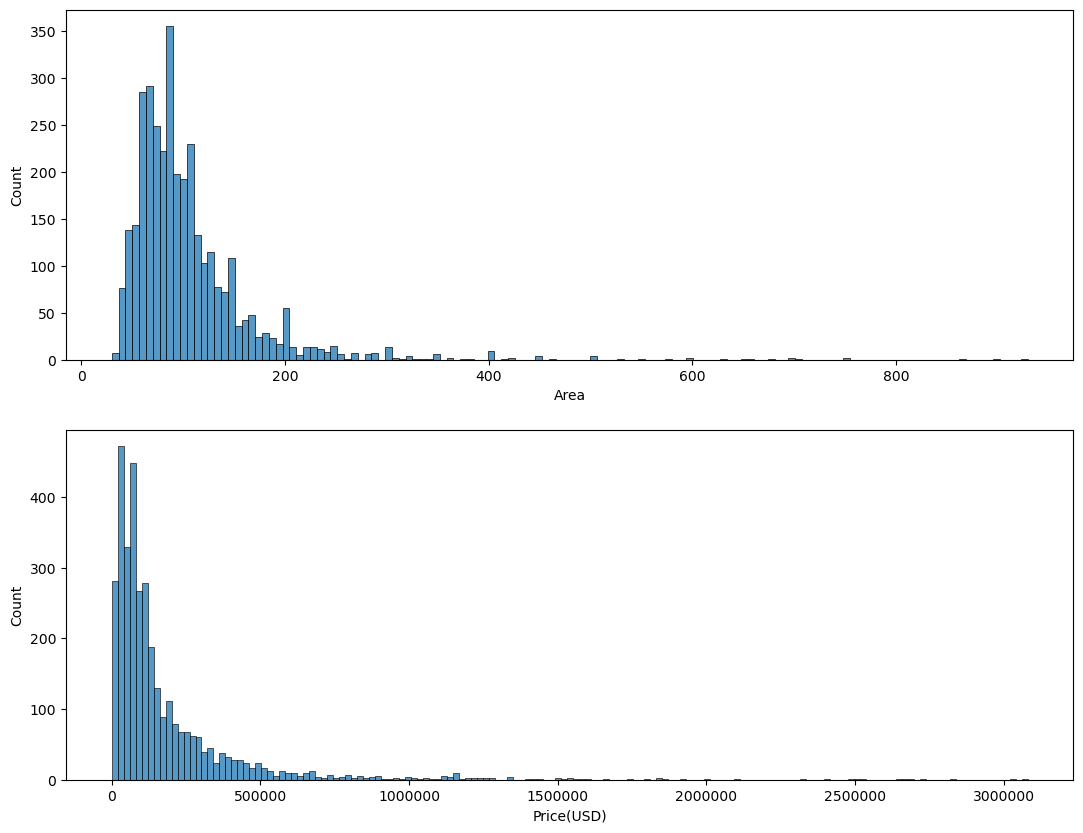

In [61]:
plt.figure(figsize = (13, 10))

plt.subplot(2, 1, 1)
sns.histplot(x = df['Area'], kde = False)

plt.subplot(2, 1, 2)
sns.histplot(x = df['Price(USD)'], kde = False)

plt.ticklabel_format(style='plain', axis='both') 
plt.show()


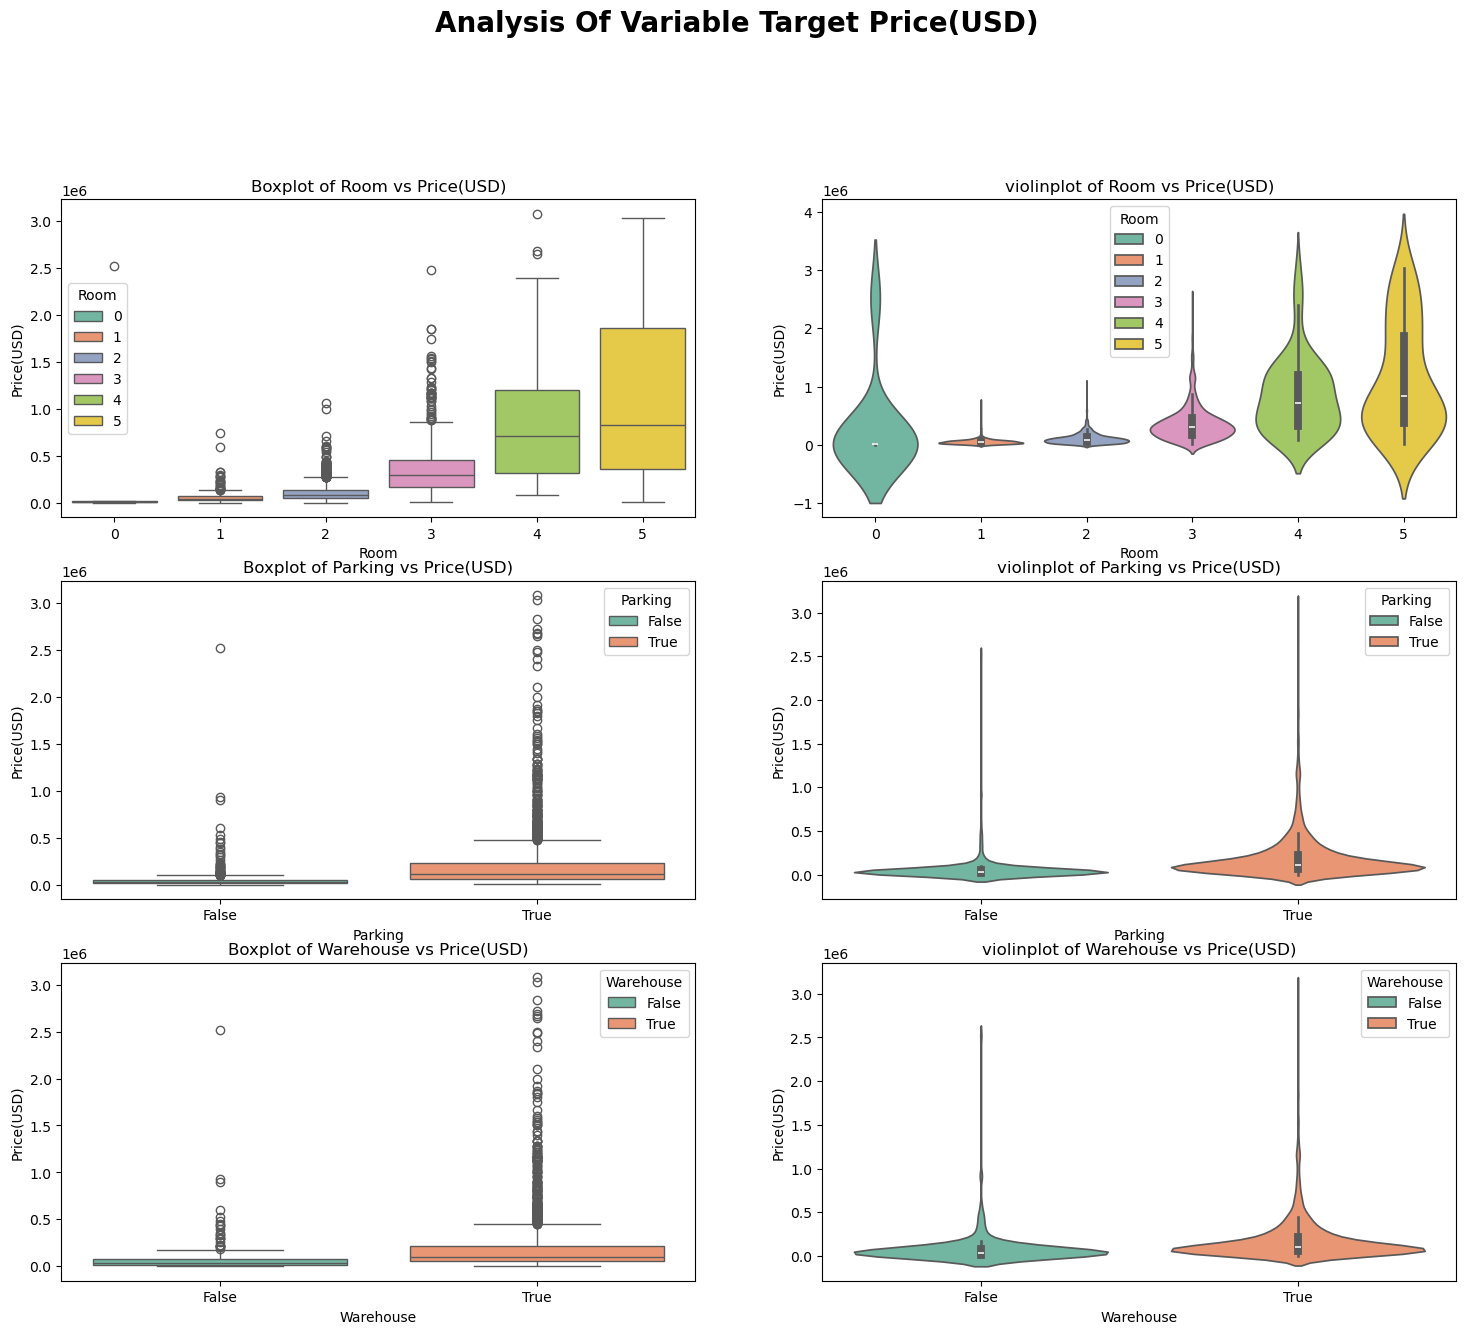

In [62]:
plt.figure(figsize=(18, 19))
plt.suptitle("Analysis Of Variable Target Price(USD)", fontweight="bold", fontsize=20)

axes=[]

axes.append(plt.subplot(4,2,1))
sns.boxplot(x='Room', y='Price(USD)', hue="Room", data=df, palette='Set2')
plt.title('Boxplot of Room vs Price(USD)')

axes.append(plt.subplot(4,2,2))
sns.violinplot(x='Room', y='Price(USD)', hue="Room", data=df, palette='Set2')
plt.title('violinplot of Room vs Price(USD)')

axes.append(plt.subplot(4,2,3))
sns.boxplot(x='Parking' , y='Price(USD)' ,hue='Parking' ,data=df ,palette='Set2')
plt.title('Boxplot of Parking vs Price(USD)')

axes.append(plt.subplot(4,2,4))
sns.violinplot(x='Parking', y='Price(USD)', hue="Parking", data=df, palette='Set2')
plt.title('violinplot of Parking vs Price(USD)')


axes.append(plt.subplot(4,2,5))
sns.boxplot(x='Warehouse' , y='Price(USD)' ,hue='Warehouse' ,data=df ,palette='Set2')
plt.title('Boxplot of Warehouse vs Price(USD)')

axes.append(plt.subplot(4,2,6))
sns.violinplot(x='Warehouse', y='Price(USD)', hue="Warehouse", data=df, palette='Set2')
plt.title('violinplot of Warehouse vs Price(USD)')

plt.show()    

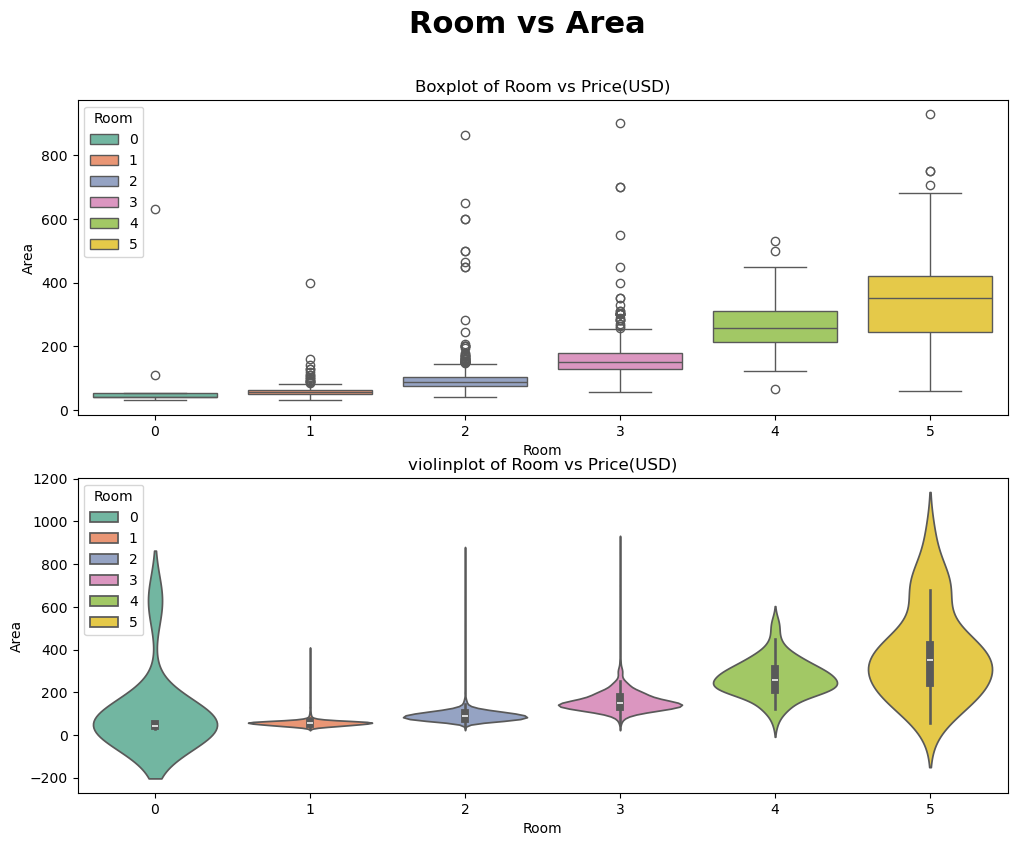

In [63]:
plt.figure(figsize=(12,9))
plt.suptitle("Room vs Area", fontweight="bold", fontsize=22)
axes=[]

axes.append(plt.subplot(2,1,1))
sns.boxplot(x='Room' , y='Area' ,hue='Room' ,data=df ,palette='Set2')
plt.title('Boxplot of Room vs Price(USD)')

axes.append(plt.subplot(2,1,2))
sns.violinplot(x='Room', y='Area', hue="Room", data=df, palette='Set2')
plt.title('violinplot of Room vs Price(USD)')
plt.show()

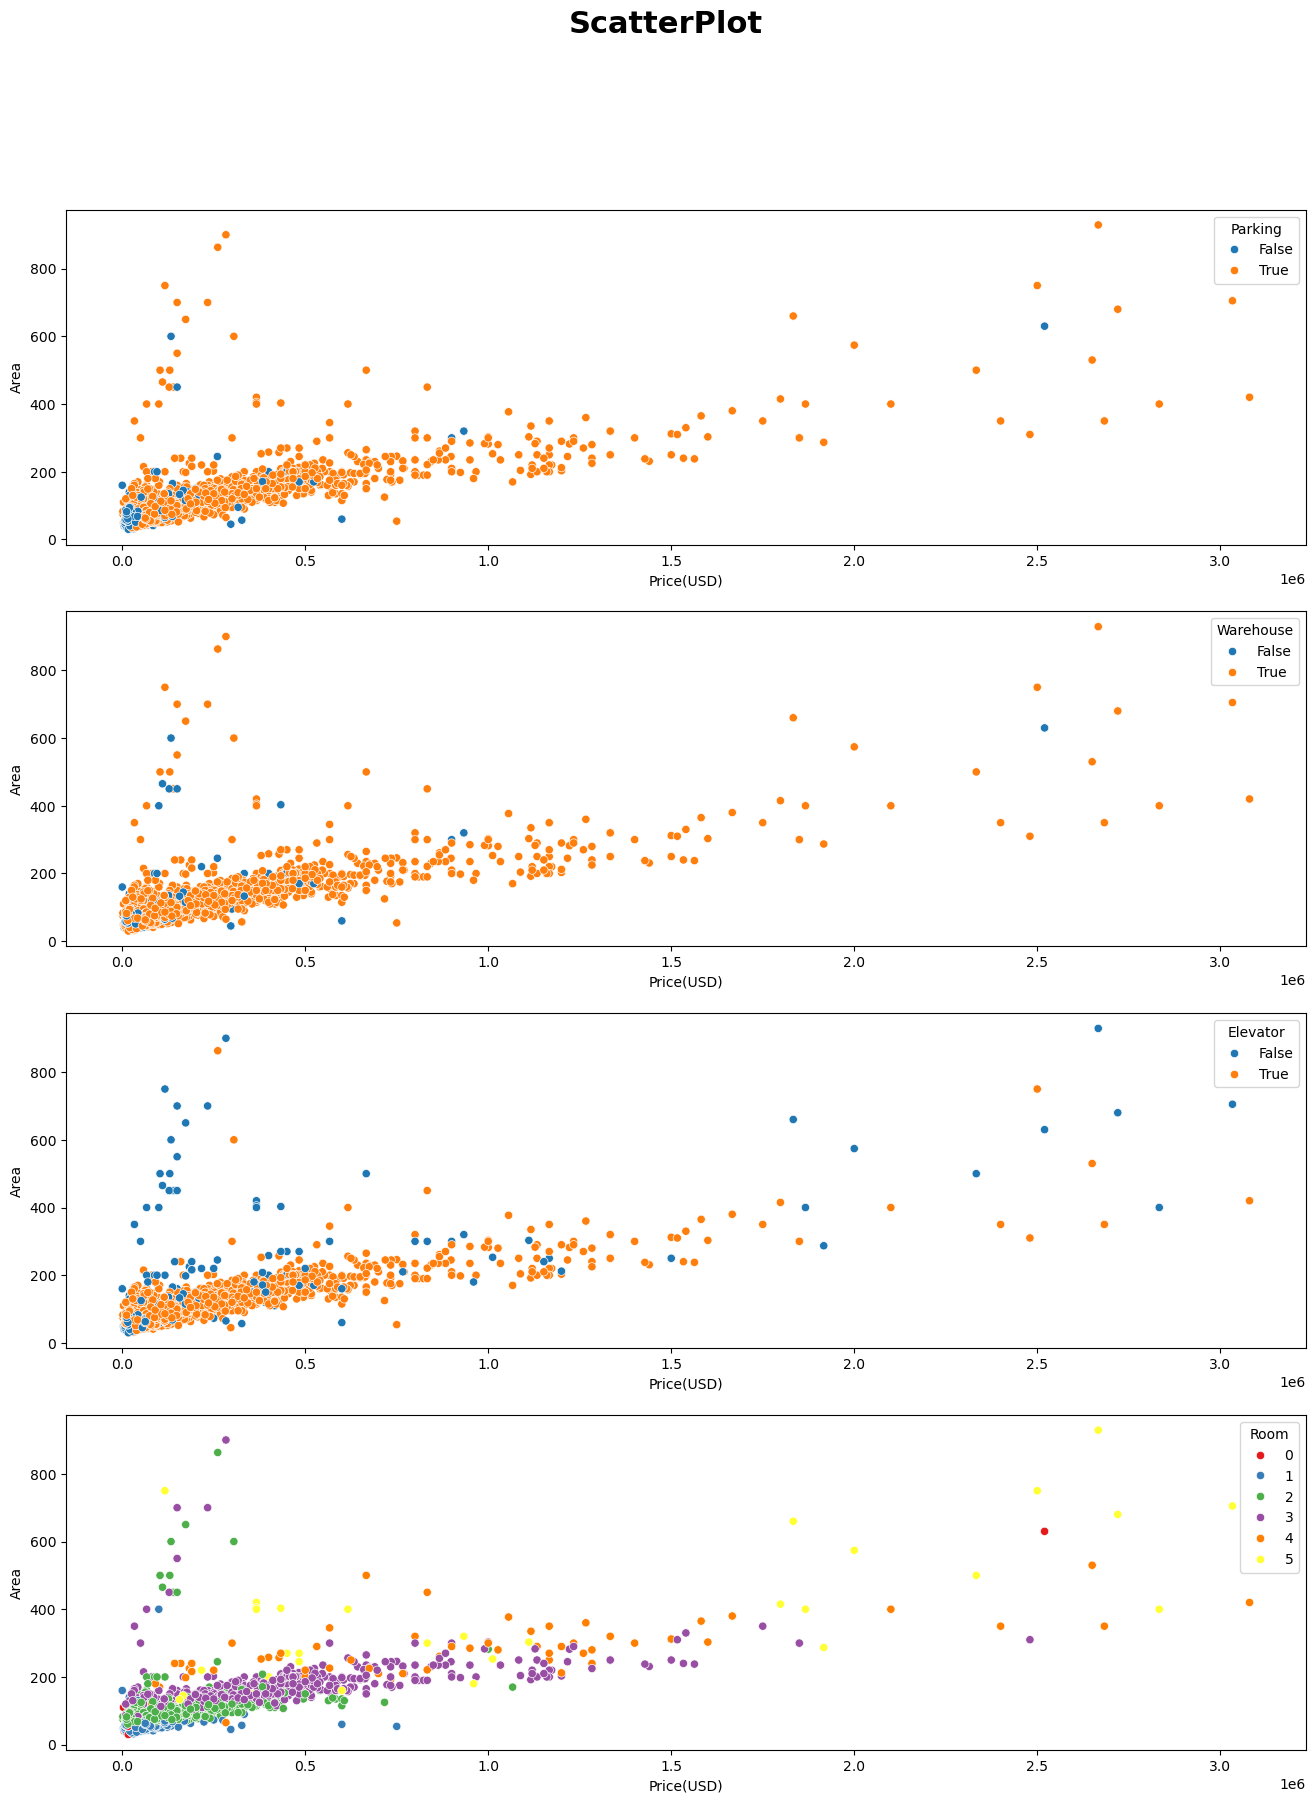

In [64]:
plt.figure(figsize=(16,20))
plt.suptitle("ScatterPlot", fontweight="bold", fontsize=22)
axes=[]

axes.append(plt.subplot(4,1,1))
sns.scatterplot(x='Price(USD)',y='Area', hue='Parking', data=df)

axes.append(plt.subplot(4,1,2))
sns.scatterplot(x='Price(USD)',y='Area', hue='Warehouse', data=df)

axes.append(plt.subplot(4,1,3))
sns.scatterplot(x='Price(USD)',y='Area', hue='Elevator', data=df)

axes.append(plt.subplot(4,1,4))
sns.scatterplot(x='Price(USD)', y='Area', hue="Room", data=df, palette="Set1")
plt.show()

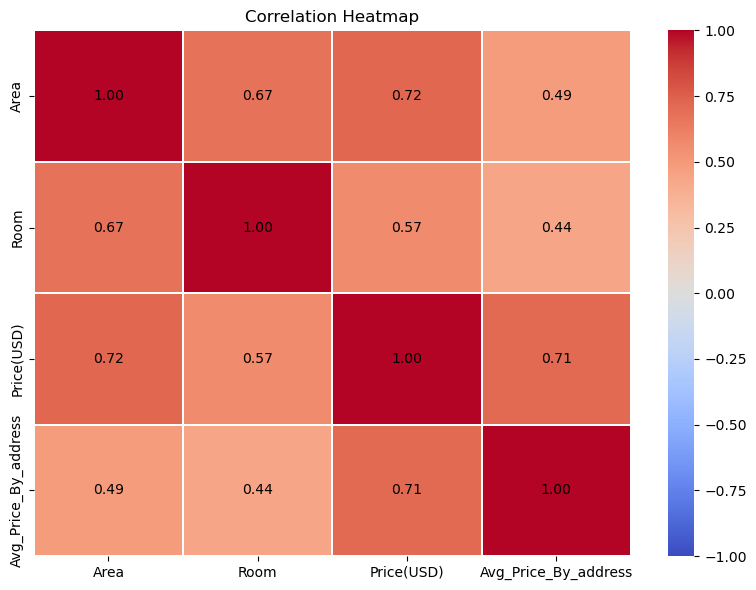

In [ ]:
# Correlation Heatmap 
numerical_columns=df[df.select_dtypes(include=['int64', 'float64']).columns]

if numerical_columns.shape[1] >= 2:
    plt.figure(figsize=(8,6))
    corr = numerical_columns.corr()
    sns.heatmap(corr, cmap='coolwarm', fmt='.2f',annot_kws={'color': 'black'}, vmin=-1, vmax=1, linewidths=0.2, annot=True)
    plt.title('Correlation Heatmap')
    plt.tight_layout()
    plt.show()
else:
    print('Not enough numeric columns for a correlation heatmap.')